## Step-by-Step PyTorch CNN for Car Model Classification (Swift, Alto, Baleno, Brezza)


#### 1. Import Libraries

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os

#### 2. Configuration

In [52]:
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 50
LEARNING_RATE = 0.001
SEED = 42

torch.manual_seed(SEED)

#### 3. Dataset and Transformations

In [53]:
train_transform = transforms.Compose([
  transforms.Resize((128,128)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
  transforms.ToTensor(),
  transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
  transforms.Resize((128,128)),
  transforms.ToTensor(),
  transforms.Normalize([0.5]*3, [0.5]*3)
])

In [54]:
train_dataset = datasets.ImageFolder("./dataset/train", transform=train_transform)

val_dataset = datasets.ImageFolder("./dataset/val", transform=test_transform)
test_dataset = datasets.ImageFolder("./dataset/test", transform=test_transform)

In [55]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### 4. Visualize Augmented Images

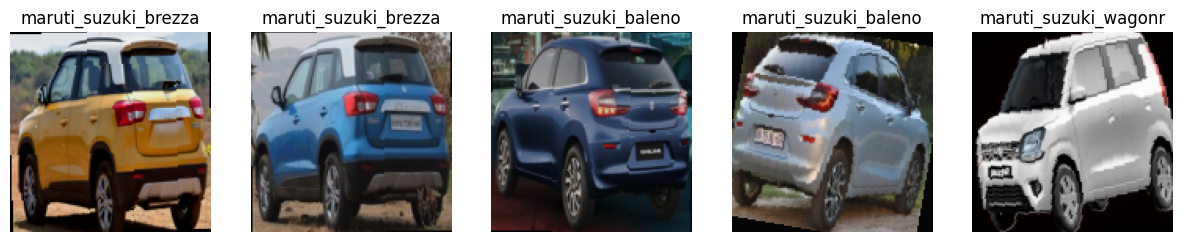

In [56]:
def show_augmented_images(loader):
  images, labels = next(iter(loader))
  fig, axes = plt.subplots(1, 5, figsize=(15,5))
  for i in range(5):
    img = images[i].permute(1,2,0) * 0.5 + 0.5 
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(train_dataset.classes[labels[i]])
  plt.show()
  
show_augmented_images(train_loader)

#### 5. CNN Model from Scratch

In [57]:
class CarModelCNN(nn.Module):
  def __init__(self):
    super(CarModelCNN, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

      nn.Conv2d(32,64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2,2),

      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(128 * 16 * 16, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, NUM_CLASSES)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x
  
model = CarModelCNN()

#### 6. Loss, Optimizer, Scheduler

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CarModelCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=512, bias=True)
    (2): ReLU()
    (3): Dro

#### 7. Training Loop

In [59]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        train_acc.append(acc)
        
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_acc.append(val_accuracy)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {acc:.2f}%, Val Acc: {val_accuracy:.2f}%")
    return train_acc, val_acc

train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS)

Epoch [1/50], Train Acc: 38.01%, Val Acc: 48.19%
Epoch [2/50], Train Acc: 51.53%, Val Acc: 48.19%
Epoch [3/50], Train Acc: 52.04%, Val Acc: 44.58%
Epoch [4/50], Train Acc: 55.10%, Val Acc: 59.04%
Epoch [5/50], Train Acc: 61.48%, Val Acc: 59.04%
Epoch [6/50], Train Acc: 66.84%, Val Acc: 65.06%
Epoch [7/50], Train Acc: 71.17%, Val Acc: 71.08%
Epoch [8/50], Train Acc: 70.41%, Val Acc: 69.88%
Epoch [9/50], Train Acc: 68.37%, Val Acc: 65.06%
Epoch [10/50], Train Acc: 73.98%, Val Acc: 71.08%
Epoch [11/50], Train Acc: 75.51%, Val Acc: 69.88%
Epoch [12/50], Train Acc: 74.74%, Val Acc: 71.08%
Epoch [13/50], Train Acc: 73.21%, Val Acc: 68.67%
Epoch [14/50], Train Acc: 79.59%, Val Acc: 71.08%
Epoch [15/50], Train Acc: 78.57%, Val Acc: 73.49%
Epoch [16/50], Train Acc: 78.83%, Val Acc: 72.29%
Epoch [17/50], Train Acc: 81.38%, Val Acc: 74.70%
Epoch [18/50], Train Acc: 81.12%, Val Acc: 74.70%
Epoch [19/50], Train Acc: 79.08%, Val Acc: 71.08%
Epoch [20/50], Train Acc: 79.85%, Val Acc: 74.70%
Epoch [21

####  8. Plot Accuracy Curves

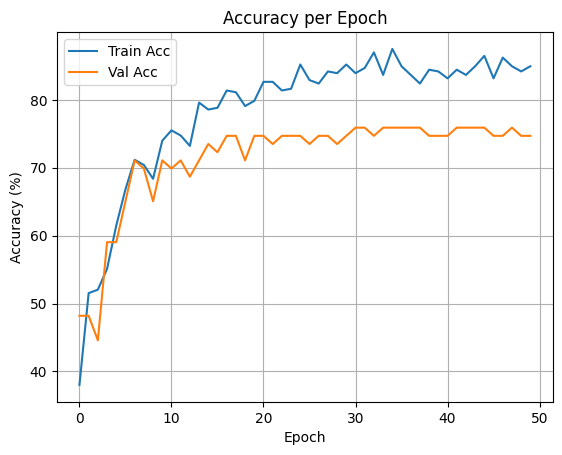

In [60]:
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

#### 9. Evaluate on Test Set

In [61]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

evaluate(model, test_loader)

Test Accuracy: 82.95%


#### Save the entire model

In [62]:
torch.save(model, 'car_classifier_model.pth')

#### How to Load the Model for Classification.

If you saved the entire model

In [63]:
model = torch.load('car_classifier_model.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to device
model.eval()

C:\Users\mistr\AppData\Local\Temp\ipykernel_10496\1812641705.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('car_classifier_model.pth')


CarModelCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=512, bias=True)
    (2): ReLU()
    (3): Dro

#### How to Use This Model to Classify New Images.

You can now use the loaded model to predict any image like this.

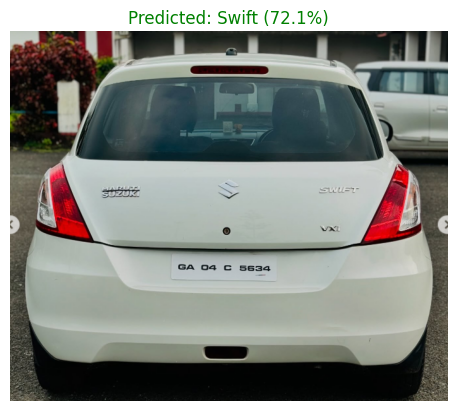

In [83]:
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

# Define class names in order
class_names = ['Brezza', 'Baleno', 'Swift', 'WagonR']

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Match your training size!
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


def predict_image(image_path, threshold=0.6):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # Move to same device

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)
        confidence = confidence.item()
        predicted = predicted.item()

    # Display image and prediction
    plt.imshow(image)
    plt.axis('off')

    if confidence < threshold:
        plt.title("Unable to classify car model", color='red')
    else:
        plt.title(f"Predicted: {class_names[predicted]} ({confidence*100:.1f}%)", color='green')
    plt.show()

# Example
predict_image("./image_sample/swift2.png")
